# Learning SVMs
This is a tutorial for coding and using SVMs from scratch. The implementation will be compared to the standard ones availabe in sklearn.  
It covers learning SVMs for linearly separable data, Kernel Methods in SVMs for linearly non-separable data and multiclass SVMs(?)

In [2]:
# Importing stuff
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
from sklearn.svm import SVC
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

## SVMs for Linearly Separable Data (Hard Margin Classifiers)
The objective is to learn the discriminant function of a hyperplane which will separate the two classes. First we will look at hard margin SVMs

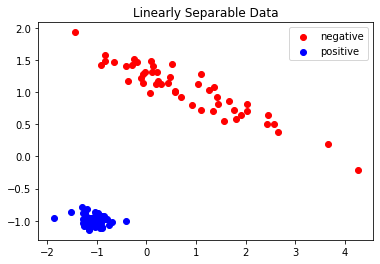

In [44]:
# Data
separable = False
while not separable:
    X,y = datasets.make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1)
    red = X[y == 0]
    blue = X[y == 1]
    separable = any([red[:, k].max() < blue[:, k].min() or red[:, k].min() > blue[:, k].max() for k in range(2)])
plt.scatter(red[:,0],red[:,1],color='r',label='negative')
plt.scatter(blue[:,0],blue[:,1],color='b',label='positive')
plt.legend()
plt.title("Linearly Separable Data")
plt.show()
y[y==0] = -1
y = y.reshape(-1,1)*1.0


Refer to page 4 in svm.txt for the reference on why we use the dual form of lagrange function to optimize. Refer to Pages 9,10 about how this is translated to cvxopt.

In [45]:
# Learning Decision Boundary

def initialize_params(X):
    w = np.random.randn(X.shape[1])
    b = 0
    return w,b

w,b = initialize_params(X)

def init_cvxopt_params(X,y):
    Xy = np.multiply(X,y)
    H = cvxopt_matrix(np.dot(Xy,Xy.T))
    q = cvxopt_matrix(-1*np.ones(y.shape))
    G = cvxopt_matrix(-1*np.eye(X.shape[0]))
    h = cvxopt_matrix(np.zeros(y.shape))
    A = cvxopt_matrix(y.T*1.0)
    b = cvxopt_matrix(np.zeros(1))

    return (H,q,G,h,A,b)

(H,q,G,h,A,b) = init_cvxopt_params(X,y)

cvxopt_solvers.options['show_progress'] = False
cvxopt_solvers.options['abstol'] = 1e-10
cvxopt_solvers.options['reltol'] = 1e-10
cvxopt_solvers.options['feastol'] = 1e-10

sol = cvxopt_solvers.qp(H, q, G, h, A, b)
alphas = np.array(sol['x'])
sv = (alphas > 1e-4).flatten()

w = np.dot(X.T,np.multiply(y,alphas))
b = np.array(np.mean(y[sv] - np.dot(X[sv],w)))

clf = SVC(C = 10, kernel = 'linear')
clf.fit(X, y.ravel()) 

print(f'w -> Sklearn: {clf.coef_}, Our Model: {w.T}')
print(f'b -> Sklearn: {clf.intercept_}, Our Model: {b}')


w -> Sklearn: [[-0.27111752 -0.94038241]], Our Model: [[-0.27133113 -0.94033205]]
b -> Sklearn: [-0.05618589], Our Model: -0.056106866899188756


In [46]:
def plot_decision_boundary(X,y,model_params,sklearn_params):
    w,b = model_params
    clf = sklearn_params
    x_lin = np.linspace(min(X[:,0]),max(X[:,0]),100)
    y_lin = (-w[0]/w[1])*x_lin + (-b/w[1])
    y_lin_skl = (-clf.coef_[0][0]/clf.coef_[0][1])*x_lin + (-clf.intercept_/clf.coef_[0][1])
    plt.plot(x_lin,y_lin,label='Our Model')
    plt.plot(x_lin,y_lin_skl,label='Sklearn Model')
    plt.scatter(X[y.squeeze()==-1][:,0],X[y.squeeze()==-1][:,1],color='r',label='negative')
    plt.scatter(X[y.squeeze()==1][:,0],X[y.squeeze()==1][:,1],color='b',label='positive')
    plt.legend()
    plt.title("Data with Decision Boundaries")
    plt.show()
    return


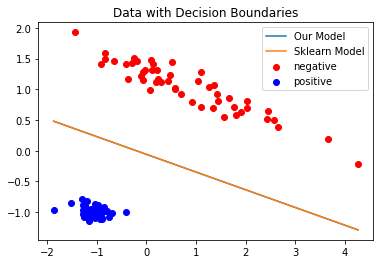

In [47]:
plot_decision_boundary(X,y,(w,b),clf)

## Non Linearly Separable Data (Soft Margin SVMs)

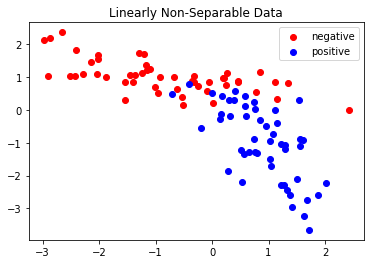

In [27]:
# Data
X,y = datasets.make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1)
y[y==0] = -1
plt.scatter(X[y==-1.][:,0],X[y==-1.][:,1],color='r',label='negative')
plt.scatter(X[y==1.][:,0],X[y==1.][:,1],color='b',label='positive')
plt.legend()
plt.title("Linearly Non-Separable Data")
plt.show()
y = np.array(y,dtype='float64').reshape(-1,1)

In [28]:
# Learning Decision Boundary

def initialize_params(X):
    w = np.random.randn(X.shape[1])
    b = 0
    return w,b

w,b = initialize_params(X)

def init_cvxopt_params_sm(X,y,C=10):
    Xy = np.multiply(X,y)
    H = cvxopt_matrix(np.dot(Xy,Xy.T))
    q = cvxopt_matrix(-1*np.ones(y.shape))
    G = cvxopt_matrix(np.vstack([-1*np.eye(X.shape[0]),np.eye(X.shape[0])])) #Note the change in the G Matrix
    h = cvxopt_matrix(np.vstack([np.zeros(y.shape),C*np.ones(y.shape)])) #Note the change in the h vector
    A = cvxopt_matrix(y.T*1.0)
    b = cvxopt_matrix(np.zeros(1))

    return (H,q,G,h,A,b)

(H,q,G,h,A,b) = init_cvxopt_params_sm(X,y,10)

cvxopt_solvers.options['show_progress'] = False
cvxopt_solvers.options['abstol'] = 1e-10
cvxopt_solvers.options['reltol'] = 1e-10
cvxopt_solvers.options['feastol'] = 1e-10

sol = cvxopt_solvers.qp(H, q, G, h, A, b)
alphas = np.array(sol['x'])
sv = (alphas > 1e-4).flatten()

w = np.dot(X.T,np.multiply(y,alphas))
b = np.array(np.mean(y[sv] - np.dot(X[sv],w)))

clf = SVC(C = 10, kernel = 'linear')
clf.fit(X, y.ravel()) 

print(f'w -> Sklearn: {clf.coef_}, Our Model: {w.T}')
print(f'b -> Sklearn: {clf.intercept_}, Our Model: {b}')

w -> Sklearn: [[ 0.49698126 -2.43614681]], Our Model: [[ 0.49698165 -2.43614707]]
b -> Sklearn: [0.71000285], Our Model: 0.8500110256405434


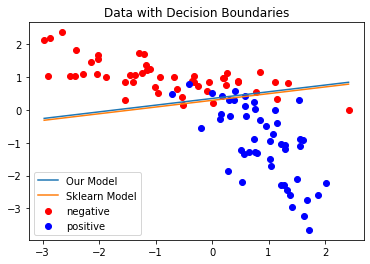

In [43]:
plot_decision_boundary(X,y,(w,b),clf)

Using Kernel's is a simple extension of the same. In the optimization function, <xi,xj> is replaced by K<xi,xj>.